# Taller 4. Mapeo de QTL por ligamiento
Genética de rasgos complejos 2024-01 - Universidad Nacional de Colombia<br>
Docente Johana Carolina Soto Sedano - jcsotos@unal.edu.co  
 
 
__Hans D. Escobar H.__ ([hdescobarh](https://github.com/hdescobarh))

Desarrollo el taller agregando algunos pasos extra e información adicional de la bibliografía para mi estudio.

In [1]:
# Environment setup

missing_packages <- character()
for (package in c(
  "qtl"
)) {
  if (!require(package, quietly = TRUE, character.only = TRUE)) {
    missing_packages <- append(missing_packages, package)
  }
}

if (length(missing_packages) > 0) {
  stop(
    sprintf(
      "Missing the following packages: %s",
      paste(missing_packages, collapse = ", ")
    ),
    call. = FALSE
  )
}

# paths validation
data_file_path <- "Private_Data/data.csv"
if (!file.exists(data_file_path)) {
  stop("Error: file doesn't exist, check the path.")
}


## 0. Explorando los datos de entrada

La estructura esperada por R/qtl para importar mapas desde CSV puede ser consultada con:

```R
help(read.cross)
```

Para formato CSV:

| Fila | Campos |
| :-: | -: |
| 1 | Nombres fenotipos \| marcadores |
| 2 | [Vacío] \| cromosomas |
| 3 | [Vacío] \| posiciones en cM |
| resto | Valores \| genotipos | 

In [2]:
raw_table <- read.table(data_file_path, header = TRUE, sep = ",")
cat(
  "Número de marcadores:", ncol(raw_table) - 1,
  "\nNúmero individuos:", nrow(raw_table) - 2
)
head(raw_table)


Número de marcadores: 1000 
Número individuos: 500

,Pheno,Mark1,Mark2,Mark3,Mark4,Mark5,Mark6,Mark7,Mark8,Mark9,⋯,Mark991,Mark992,Mark993,Mark994,Mark995,Mark996,Mark997,Mark998,Mark999,Mark1000
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,NA,1,1,1,1,1,1,1,1,1,⋯,10,10,10,10,10,10,10,10,10,10
2,NA,1,2,3,4,5,6,7,8,9,⋯,91,92,93,94,95,96,97,98,99,100
3,41.04670,0,0,0,1,1,1,0,1,0,⋯,0,0,0,1,0,0,0,1,0,0
4,-7.06822,1,0,1,1,1,1,1,0,1,⋯,0,1,1,1,0,0,0,1,1,0
5,32.00474,1,1,0,1,1,1,1,1,1,⋯,0,1,1,0,1,0,0,1,0,1
6,-13.50212,1,1,0,1,1,1,1,1,0,⋯,1,0,0,1,1,0,1,0,1,0


Es importante que los marcadores usen los mismos códigos para genotipos.

Recordemos que esta pensado para lineas endogámicas. En un _backcross_; es decir, P (homocigoto) x F1 (heterocigoto), hay dos códigos, uno por cada posible genotipo. En el caso de un _intercross_, depende de sí se puede diferenciar homocigotos o no, siendo 3 códigos cuando puede diferenciarse y 5 cuando no. 


In [4]:
cat("Genotype codes:", unique(as.numeric(raw_table[3, 2:ncol(raw_table)])))
cat("Number of missing values:", sum(is.na(raw_table[3, ])))


Genotype codes: 0 1

Number of missing values: 0

Conociendo esta información podemos cargar nuestros datos para Rqtl:

In [5]:
data <- read.cross(
  format = "csv", file = data_file_path,
  na.strings = "NA", genotype = c("0", "1")
)


 --Read the following data:
	 500  individuals
	 1000  markers
	 1  phenotypes
 --Cross type: bc 


## I. Mapeo por intervalo simple 

1. En tipo de cruce dice: bc (backcross). ¿Cuál será la relación genotípica? ¿Con SNPs 
como serían los genotipos de los padres?

En un backcross la F1 del cruce de dos lineas endogámicas se cruza como un parental; por lo tanto:

- La relación es $1 : 1 , AA : AB$.
- Los parentales deben ser homocigotos para diferentes nucleótidos AA y BB.


In [10]:
summary(data)
cat("Markers by chromosome:\n")
print(nmar(data))


    Backcross

    No. individuals:    500 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    10 
        Autosomes:      1 2 3 4 5 6 7 8 9 10 

    Total markers:      1000 
    No. markers:        100 100 100 100 100 100 100 100 100 100 
    Percent genotyped:  100 
    Genotypes (%):      AA:50.0  AB:50.0 

Markers by chromosome:
  1   2   3   4   5   6   7   8   9  10 
100 100 100 100 100 100 100 100 100 100 


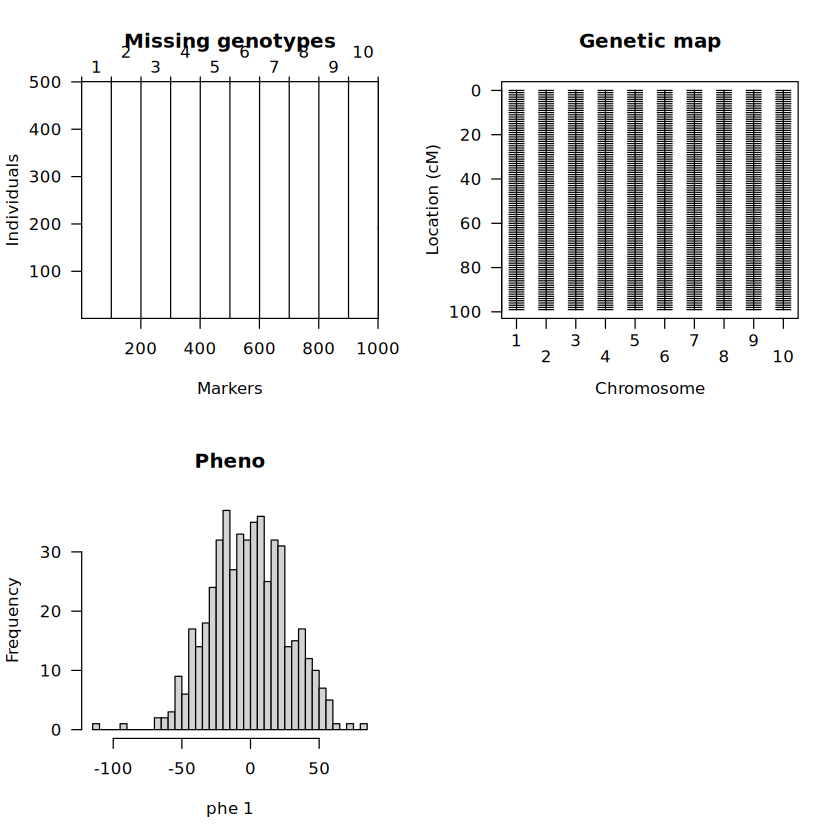

In [11]:
plot(data)


2. ¿Observando las gráficas que puede deducir de los datos?

- El mapa de ligamiento es de alta densidad: la distancia entre marcadores es 1cM, tiene alta cobertura de los cromosomas y los marcadores se distribuyen de forma homogénea.

- Visualmente el genotipo parece aproximarse a una distribución Normal. 

## Apuntes sobre _Standard interval mapping_ (SIM)

- Asume la existencia de un solo QTL.
- Asume una grid de posiciones como la posible localización del QTL.
- Las distribuciones de probabilidad del fenotipo sigue un mezcla de distribuciones normales.
- No remueve individuos con genotipo perdido en la localización del marcador. Emplea estimación por máxima verosimilitud bajo un modelo de mezclas (mixture model). 

### Desventajas

- Limitada capacidad de separar QTLs ligados.
- No evalúa interacciones entre QTLs.
- Pueden aparecer falsos LOD muy grandes en regiones con baja densidad de marcadores cuando la distribución del fenotipo es multimodal. 

In [20]:
# La función es scanone. Esta requiere para los métodos em, hk y ehk que
# primero se calculen las probabilidades multipunto

#  Calculate conditional genotype probabilities
# la mapping function relaciona frecuencias de recombinación r
# con distancias genéticas d
corrected_data <- calc.genoprob(
  data,
  error.prob = 0.001, map.function = "kosambi"
)

# Genome scan with a single QTL model
# em: maximum likelihood is performed via the EM algorithm
out_sim <- scanone(corrected_data, method = "em")

# Registra sólo un pico máximo por cromosoma
summary(out_sim) # threshold=value


,chr,pos,lod
,<fct>,<dbl>,<dbl>
Mark29,1,29,6.586314
Mark149,2,49,3.676134
Mark262,3,62,5.378991
Mark329,4,29,5.428027
Mark485,5,85,1.443209
Mark503,6,3,2.784209
Mark666,7,66,6.354468
Mark799,8,99,1.456354
Mark885,9,85,1.115737


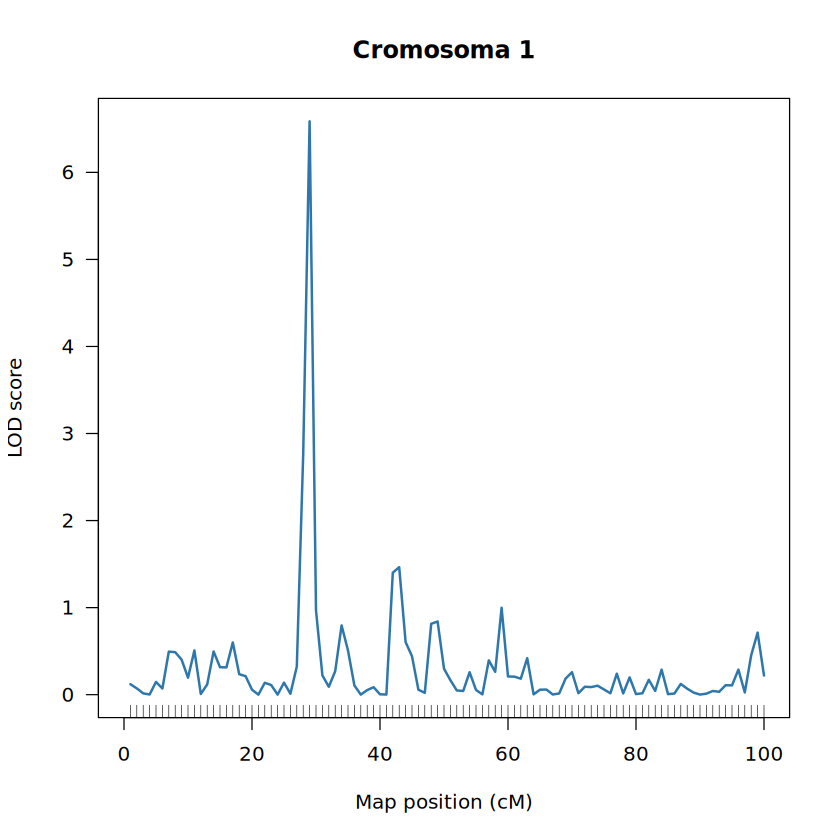

In [28]:
# Mostrando solo el cromosoma con el máximo LOD
chromosome <- max(out_sim)$chr
plot(
  out_sim,
  chr = chromosome, ylab = "LOD score", col = "#2e77ab",
  main = sprintf("Cromosoma %s", chromosome)
)


### Determinando el umbral de significancia

La hipótesis nula es que no hay QTL en todo el genoma.Para esto se emplea la distribución nula del máximo LOD de todo el genoma. Está depende de factores tales como:

- Tipo de cruce (back o inter).
- Tamaño del genoma en cM.
- Tamaño de la muestra.
- Numero de marcadores typed???
- Patron de genotipos perdidos.
- Distribución del fenotipo.

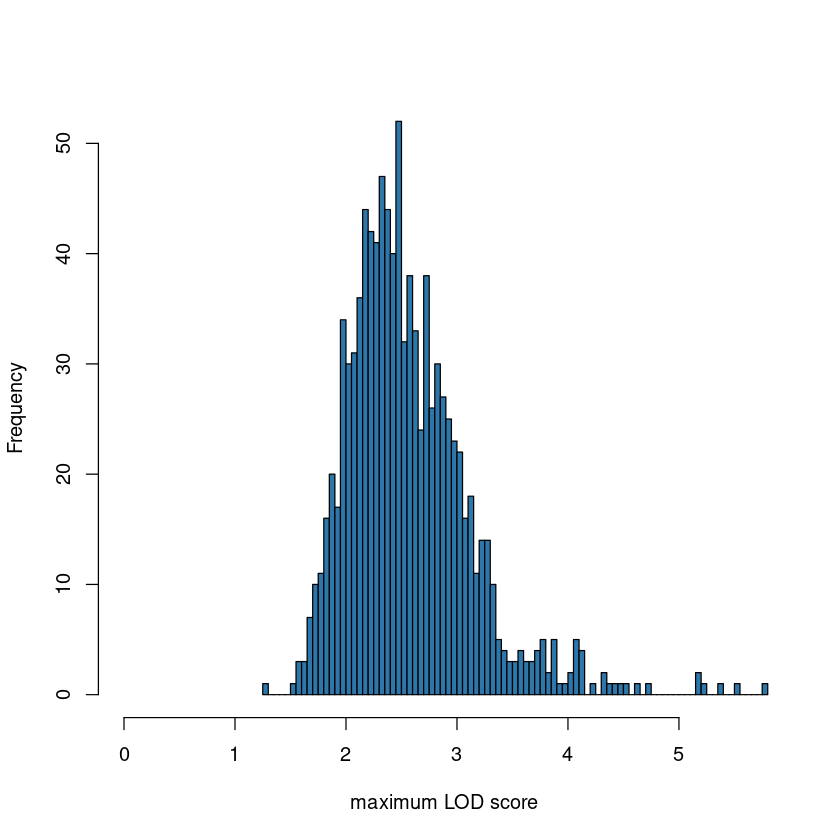

In [11]:
# Para determinarlo por permutaciones,
# primero se obtiene las máximas verosimilitudes de cada permutación
sim_max_lod_distribution <- scanone(
  corrected_data,
  n.perm = 1000, verbose = FALSE
)
plot(sim_max_lod_distribution, col = "#2e77ab")


In [12]:
# Obtener el umbral de significancia
sim_threshold_lod <- summary(sim_max_lod_distribution, alpha = 0.05)
print(sim_threshold_lod)

# Tabla mostrando solo los cromosomas con valores superiores al umbral

sim_significant <- summary(
  out_sim,
  perms = sim_max_lod_distribution, alpha = 0.05, pvalues = TRUE
)

sim_significant


LOD thresholds (1000 permutations)
    lod
5% 3.58


,chr,pos,lod,pval
,<fct>,<dbl>,<dbl>,<dbl>
Mark29,1,29,6.586314,0.000
Mark149,2,49,3.676134,0.045
Mark262,3,62,5.378991,0.003
Mark329,4,29,5.428027,0.002
Mark666,7,66,6.354468,0.000


3. ¿Cuáles son QTL estadísticamente significativos? ¿Cuál es su criterio?

Como se ve en la tabla de arriba, los marcadores 29, 149, 262, 329 y 666 son estadísticamente significativos. El criterio fué, siguiendo el procedimiento propuesto por Broman & Sen (2009), estimar el LOD umbral (α=0.05)mediante permutaciones.

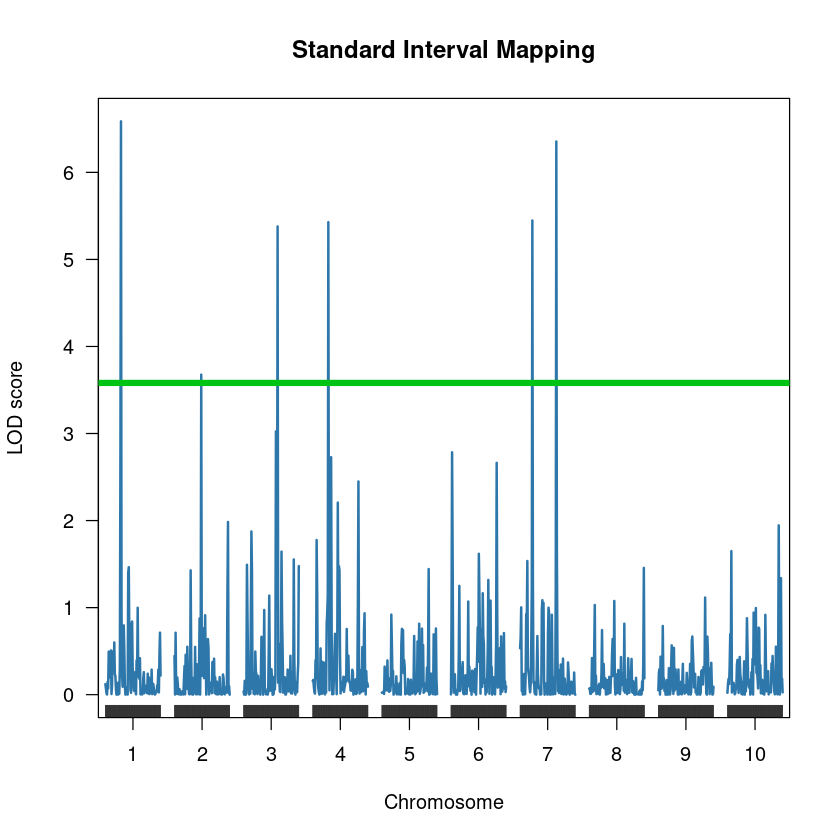

In [13]:
plot(out_sim, ylab = "LOD score", col = "#2e77ab")
abline(h = sim_threshold_lod[1], col = "#00c414", lwd = 5)
title(main = "Standard Interval Mapping")


### Estimación del intervalo de localización del QTL

Mayormente se emplean dos métodos:

- Intervalos soportados por LOD (lodint)
- Intervalo creíble (bayesint)

In [31]:
# QTL dentro del intervalo de 1.5 LOD entorno al pico del cromosoma
# con expandtomarkers flanquea el intervalo por marcadores cercanos
sim_best_QTL_interval <- lodint(out_sim,
  chr = as.numeric(max(out_sim)$chr),
  drop = 1.5,
  expandtomarkers = TRUE
)

cat(
  "Intervalo 1.5 LOD entorno al mejor marcador (", max(out_sim)$chr, ")",
  sep = ""
)
sim_best_QTL_interval


Intervalo 1.5 LOD entorno al mejor marcador (1)

,chr,pos,lod
,<fct>,<dbl>,<dbl>
Mark28,1,28,2.7604808
Mark29,1,29,6.5863137
Mark30,1,30,0.9685166


### Efectos del QTL

La proporción de la varianza fenotípica explicada por el QTL o su heredabilidad está dada por:

$$h^2 = \frac{var\{\mathbb{E}(\text{phenotype}|\text{QTL genotype})\}}{var(\text{phenotype})}$$

  QTL object containing genotype probabilities. 

     name chr pos n.gen
Q1 1@28.0   1  28     2
Q2 1@29.0   1  29     2
Q3 1@30.0   1  30     2


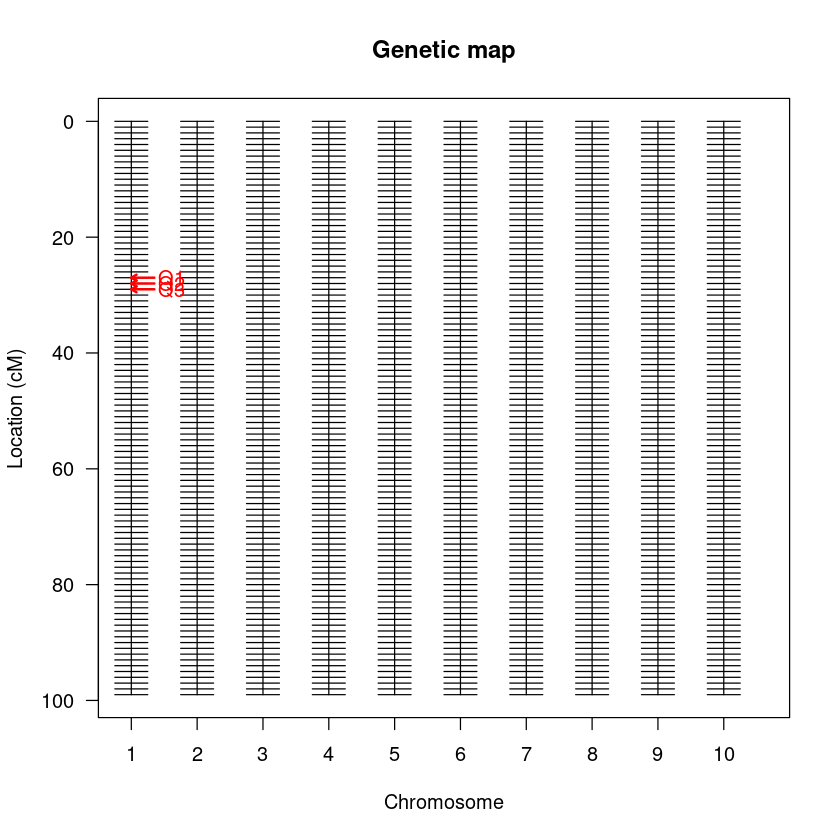

In [15]:
# Especifica el conjunto de QTL putativos a considerar
sim_best_interval_qtl <- makeqtl(
  corrected_data,
  chr = sim_best_QTL_interval$chr,
  pos = sim_best_QTL_interval$pos, what = "prob"
)
print(sim_best_interval_qtl)
plot(sim_best_interval_qtl)


In [16]:
# Ajusta el modelo de QTL definido. Permite agregar
# interacciones entre QTL y covariables

sim_fitted_model <- fitqtl(
  corrected_data,
  qtl = sim_best_interval_qtl, formula = "y~Q1 + Q2 + Q3",
  method = "hk", get.ests = TRUE
)
summary(sim_fitted_model)



		fitqtl summary

Method: Haley-Knott regression 
Model:  normal phenotype
Number of observations : 500 

Full model result
----------------------------------  
Model formula: y ~ Q1 + Q2 + Q3 

       df        SS        MS      LOD     %var Pvalue(Chi2)    Pvalue(F)
Model   3  23325.72 7775.2405 6.861454 6.124085 6.360063e-07 7.081016e-07
Error 496 357559.31  720.8857                                            
Total 499 380885.03                                                      


Drop one QTL at a time ANOVA table: 
----------------------------------  
       df Type III SS      LOD     %var  F value Pvalue(Chi2) Pvalue(F)    
1@28.0  1       9.381 0.002849 0.002463  0.01301        0.909     0.909    
1@29.0  1   12641.309 3.772263 3.318930 17.53580        0.000  3.34e-05 ***
1@30.0  1    1541.429 0.467052 0.404697  2.13824        0.142     0.144    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Estimated effects:
-----------------
             est     S

## II. Mapeo por intervalo compuesto

## Apuntes sobre _Composite interval mapping_ (CIM)

Aprovecha el uso de marcadores como covariables para reducir para reducir la varianza residual(i.e. aquella que no puede ser explicada por las variables en el modelo) y, con ello, aumenta el poder para detectar otros QTL. La idea detrás es que el marcador es un proxy para un QTL.

- Considera un marcador al tiempo.
- Primero agrega un marcador, el que mejor explica el fenotipo.
- Luego prueba otros marcadores a la vez, y se agrega el que cuyo modelo reduce mas el residual.
- Continua hasta completar el número de marcadores definido dentro de la ventana especificada.
- Aplica un interval mapping (e.g., standard interval, Haley & Knott) con esos marcadores como covariables
- Calcula el LOD comparando dos modelos: el modelo con el QTL putativo en la presencia de covariables y el modelo con solo las covariables (realmente un subconjunto de estas a una distancia mayor a una distancia fija d del QTL putativo). __Creo__ que esto sería que calcula un LOD condicional $\mathcal{L}(\text{QTL putativo} + \text{covariables }|x)/\mathcal{L}(\text{covariables }|x)$, pero no estoy seguro.



Me llama la atención lo siguiente:

> "While the use of markers near putative QTL as covariates in the search for
additional loci is a clearly useful exploratory strategy, we recommend against
the general use of composite interval mapping. CIM attempts to turn the
multidimensional search for QTL into a single-dimensional search by first
identifying a subset of covariates. The choice of covariates is critical: if too
many or too few markers are chosen, there will be a loss of power to detect
QTL. Furthermore, the subsequent scan fails to account for the uncertainty
in the choice of relevant marker covariates and can give an overly optimistic
view of the precision of localization of QTL." (Broman & Sen, 2009, p. 229)

In [17]:
out_cim <- cim(
  corrected_data,
  n.marcovar = 3, window = 10, method = "em",
  error.prob = 0.0001, map.function = "kosambi"
)
summary(out_cim)


,chr,pos,lod
,<fct>,<dbl>,<dbl>
Mark29,1,29,6.675059
Mark149,2,49,4.480554
Mark262,3,62,7.119321
Mark329,4,29,6.063030
Mark459,5,59,1.410820
Mark503,6,3,3.660897
Mark666,7,66,8.222119
Mark764,8,64,1.050828
Mark861,9,61,1.464764


In [18]:
# Obtener distribución de máx. LODs
cim_max_lod_distribution <- cim(
  corrected_data,
  n.marcovar = 3, window = 10, method = "em",
  error.prob = 0.0001, map.function = "kosambi",
  n.perm = 1000
)

# Obtener el umbral de significancia
cim_threshold_lod <- summary(cim_max_lod_distribution, alpha = 0.05)
print(cim_threshold_lod)


# Tabla mostrando solo los cromosomas con valores superiores al umbral
cim_significant <- summary(
  out_cim,
  perms = cim_max_lod_distribution, alpha = 0.05, pvalues = TRUE
)

cim_significant


LOD thresholds (1000 permutations)
   [,1]
5% 3.61


,chr,pos,lod,pval
,<fct>,<dbl>,<dbl>,<dbl>
Mark29,1,29,6.675059,0.000
Mark149,2,49,4.480554,0.004
Mark262,3,62,7.119321,0.000
Mark329,4,29,6.063030,0.000
Mark503,6,3,3.660897,0.043
Mark666,7,66,8.222119,0.000


       chr pos      lod
Mark28   1  28 2.463513
Mark29   1  29 6.675059
Mark30   1  30 1.345068


,name,chr,pos,n.gen
,<fct>,<fct>,<dbl>,<int>
Q1,1@28.0,1,28,2
Q2,1@29.0,1,29,2
Q3,1@30.0,1,30,2


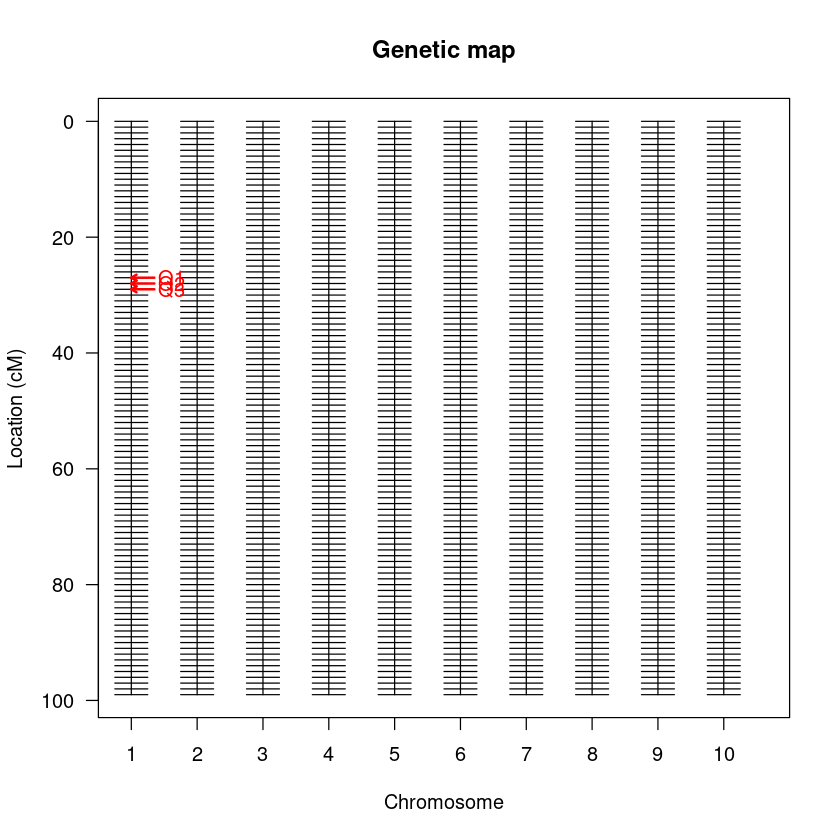

In [19]:
cim_best_QTL_interval <- lodint(out_cim,
  chr = as.numeric(max(out_cim)$chr),
  drop = 1.5,
  expandtomarkers = TRUE
)

print(cim_best_QTL_interval)

cim_best_interval_qtl <- makeqtl(
  corrected_data,
  chr = cim_best_QTL_interval$chr,
  pos = cim_best_QTL_interval$pos, what = "prob"
)

summary(cim_best_interval_qtl)
plot(cim_best_interval_qtl)


In [20]:
cim_fitted_model <- fitqtl(
  corrected_data,
  qtl = cim_best_interval_qtl, formula = "y~Q1 + Q2 + Q3",
  method = "hk", get.ests = TRUE
)
summary(cim_fitted_model)



		fitqtl summary

Method: Haley-Knott regression 
Model:  normal phenotype
Number of observations : 500 

Full model result
----------------------------------  
Model formula: y ~ Q1 + Q2 + Q3 

       df        SS        MS      LOD     %var Pvalue(Chi2)    Pvalue(F)
Model   3  23325.72 7775.2405 6.861454 6.124085 6.360063e-07 7.081016e-07
Error 496 357559.31  720.8857                                            
Total 499 380885.03                                                      


Drop one QTL at a time ANOVA table: 
----------------------------------  
       df Type III SS      LOD     %var  F value Pvalue(Chi2) Pvalue(F)    
1@28.0  1       9.381 0.002849 0.002463  0.01301        0.909     0.909    
1@29.0  1   12641.309 3.772263 3.318930 17.53580        0.000  3.34e-05 ***
1@30.0  1    1541.429 0.467052 0.404697  2.13824        0.142     0.144    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Estimated effects:
-----------------
             est     S

## 4. Porcentaje de varianza explicada por el QTL

En el taller se sugiere la siguiente función:

$$1-10^{\frac{-2 \cdot \text{ LOD QTL}}{\text{tamaño población}}}$$


En principio es la misma que usa internamente __fitqtl__:

$$h^2 = 1 - 10^{-(2/n) {\rm LOD}}$$

Pero creo que está no se puede aplicar directamente a los LOD obtenidos en el mapeo estándar (SIM) y compuesto (CIM).

En el caso de fitqtl se refiere a la puntuación LOD __condicional__, qué es comparando el modelo completo con el modelo omitiendo la posición evaluada. Estos valores están en "Drop one QTL at a time ANOVA table" y son diferentes del LOD del modelo.

Ademas, en el caso de SIM entiendo que su LOD relaciona la verosimilitud de un solo QTL respecto a la hipótesis nula de que no hay QTL en todo el genoma. En el caso de CIM es un LOD comparando el modelo de un QTL putativo en presencia de covariables respecto al modelo sin incluir el QTL putativo y lo hace con __scanone__. 

In [21]:
get_pve <- function(sample_size, qtl_lod) {
  r2 <- 1 - 10^(-2 * qtl_lod / sample_size)
  return(100 * r2)
}

qtl_model_lod_pve <- function(data, chr, pos) {
  fitted_model <- qtl::fitqtl(
    data,
    qtl = qtl::makeqtl(
      data,
      chr = chr,
      pos = pos, what = "prob"
    ), formula = "y~Q1",
    method = "hk", get.ests = TRUE
  )
  return(
    c(
      fitted_model$result.full["Model", "LOD"],
      fitted_model$result.full["Model", "%var"]
    )
  )
}


In [22]:
marker_chr <- 7
marker_pos <- 66
marker_name <- find.marker(corrected_data, marker_chr, marker_pos)

cat(sprintf("Marcador: %s\n", marker_name))

cat(sprintf(
  "\n- SIM (scanone, model = 'em'):\n\tSIM LOD: %.5f\n",
  sim_significant[marker_name, "lod"]
))

cat(sprintf("\tFormula aplicada a SIM LOD: %.5f\n", get_pve(
  sample_size = nind(corrected_data),
  qtl_lod = sim_significant[marker_name, "lod"]
)))
cat(sprintf(
  "\n- CIM (cim, model = 'em'):\n\tCIM LOD: %.5f\n",
  cim_significant[marker_name, "lod"]
))
cat(sprintf("\tFormula aplicada a CIM LOD: %.5f\n", get_pve(
  sample_size = nind(corrected_data),
  qtl_lod = cim_significant[marker_name, "lod"]
)))

qtl_model_vals <- qtl_model_lod_pve(
  corrected_data,
  chr = marker_chr,
  pos = marker_pos
)

cat(sprintf(
  "\n- Fitted model (fitmodel y~Q1):
  \tLOD del modelo con un ÚNICO marcador: %.5f
  \tPVE del modelo: %.5f
  \tFormula aplicada al LOD del modelo: %.5f",
  qtl_model_vals[1], qtl_model_vals[2], get_pve(
    sample_size = nind(corrected_data),
    qtl_lod = qtl_model_vals[1]
  )
))


Marcador: Mark666

- SIM (scanone, model = 'em'):
	SIM LOD: 6.35447
	Formula aplicada a SIM LOD: 5.68471

- CIM (cim, model = 'em'):
	CIM LOD: 8.22212
	Formula aplicada a CIM LOD: 7.29321

- Fitted model (fitmodel y~Q1):
  	LOD del modelo con un ÚNICO marcador: 6.34470
  	PVE del modelo: 5.67622
  	Formula aplicada al LOD del modelo: 5.67622

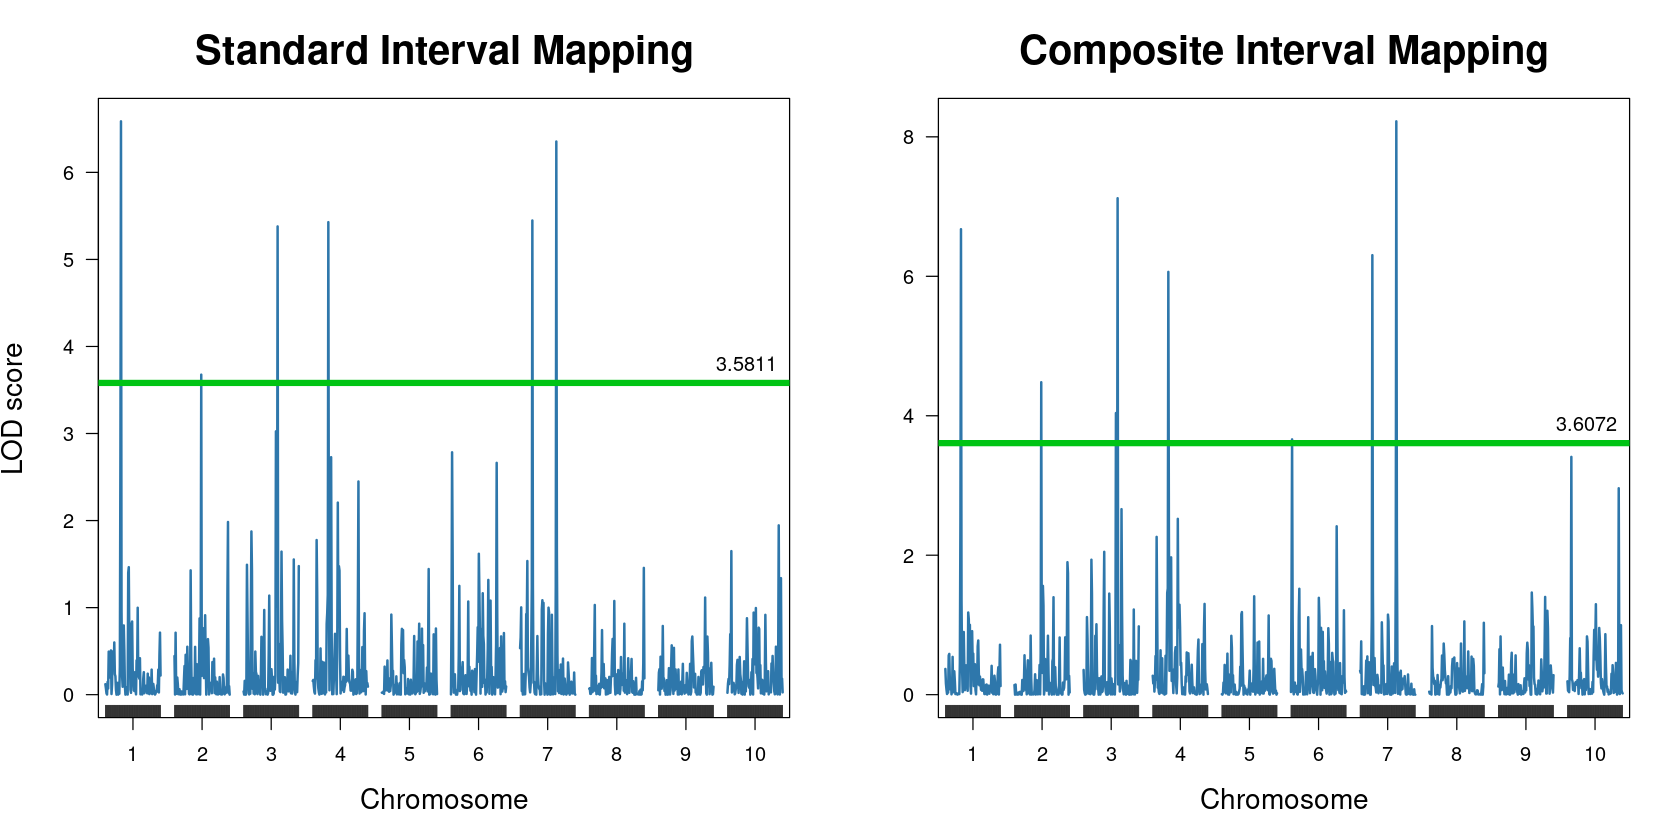

In [23]:
options(repr.plot.width = 14, repr.plot.height = 7)
par(mfcol = c(1, 2))
plot(out_sim,
  ylab = "LOD score", col = "#2e77ab",
  main = "Standard Interval Mapping", cex.main = 2, cex.lab = 1.4
)
abline(h = sim_threshold_lod[1], col = "#00c414", lwd = 5)
text(1150, sim_threshold_lod[1],
  sprintf("%.4f", sim_threshold_lod[1]),
  srt = 0.5, pos = 3
)
plot(out_cim,
  ylab = "", col = "#2e77ab",
  main = "Composite Interval Mapping", cex.main = 2, cex.lab = 1.4
)
abline(h = cim_threshold_lod[1], col = "#00c414", lwd = 5)
text(1150, cim_threshold_lod[1],
  sprintf("%.4f", cim_threshold_lod[1]),
  srt = 0.5, pos = 3
)


## Bibliografía

- Broman, K. W., & Sen, S. (2009). A Guide to QTL Mapping with R/qtl. Springer New York. https://doi.org/10.1007/978-0-387-92125-9
